# Week 4 Assignment
### Kaggle: Natural Language Processing with Disaster Tweets

By: Austin Jenkins

Class: CSCA 5642 - Introduction to Deep Learning

Github Repository: https://github.com/ajenkins198621/csca-5642-module4-disaster-tweets
Kaggle Competition: 

## Introduction

In this assignment from the Kaggle competition "Natural Language Processing with Disaster Tweets", we are tasked with creating a model that can predict whether a tweet is about a real disaster or not.

As this week we learned about Recurrent Neural Networks (RNNs), I will be focusing on those types of models for this assignment.  

#### Import Libraries

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import keras
import numpy as np
from keras.layers import TextVectorization, Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping




#### Set Default Plot Styles

In [35]:
plt.style.use('dark_background')

disaster_color = "#A31621"
non_disaster_color = "#1F7A8C"

#### Load The Data

Here we'll load the data and store them in a pandas dataframe.

In [36]:
DATA_DIRECTORY = 'nlp-getting-started'

train_df = pd.read_csv(DATA_DIRECTORY + '/train.csv')
test_df = pd.read_csv(DATA_DIRECTORY + '/test.csv')

## EDA

#### Data Inspection

First off, let's take a look at the data for both the training and test data.

In [37]:
print("----- TRAIN DATA (train_df) -----")
train_df.head()

----- TRAIN DATA (train_df) -----


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [38]:
print("\n----- TEST DATA (test_df) -----")
test_df.head()


----- TEST DATA (test_df) -----


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


From inspecting the head of the data, we can see there are 5 columns in the training data and 4 in the test data.  The training data has a target column which is the target variable we are trying to predict.  The test data does not have this column.

Within the target column in the training data, we can see that the target variable is binary, with 1 indicating a real disaster tweet and 0 indicating a non-disaster tweet.

Now, I'll take a look at the info of the data using the info() and describe() methods.

In [39]:
print("----- TRAIN DATA (train_df) -----")
train_df.info()
train_df.describe()

----- TRAIN DATA (train_df) -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [40]:
print("----- TEST DATA (test_df) -----")
test_df.info()
test_df.describe()

----- TEST DATA (test_df) -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


As we can see from the info function, the training data has 7,613 rows and the test data has 3,263 rows.

#### Data Histograms

Now, I'll take a look at the histograms of the data to see the distribution of the data.  I'll take a look at a bar and pie chart of the target variable to see the distribution of the target variable.

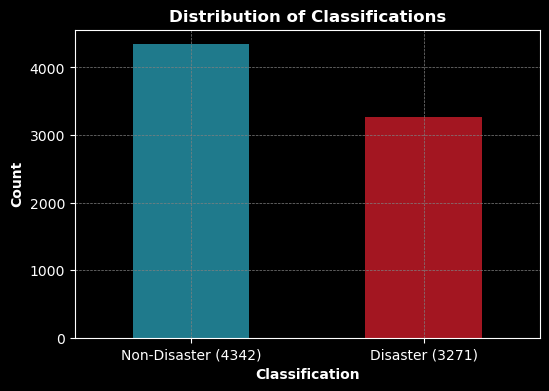

In [41]:
classification_counts = train_df['target'].value_counts()

non_disaster_count = classification_counts[0]
disaster_count = classification_counts[1]

classification_counts.plot(kind='bar', color=[non_disaster_color, disaster_color], figsize=(6, 4))

labels = [f"Non-Disaster ({non_disaster_count})", f"Disaster ({disaster_count})"]

plt.title("Distribution of Classifications", fontweight='bold')
plt.xlabel("Classification", fontweight='bold')
plt.ylabel("Count", fontweight='bold')
plt.xticks([0, 1], labels, rotation=0)
plt.grid(True, linewidth=0.5, color='gray', linestyle='--')
plt.show()

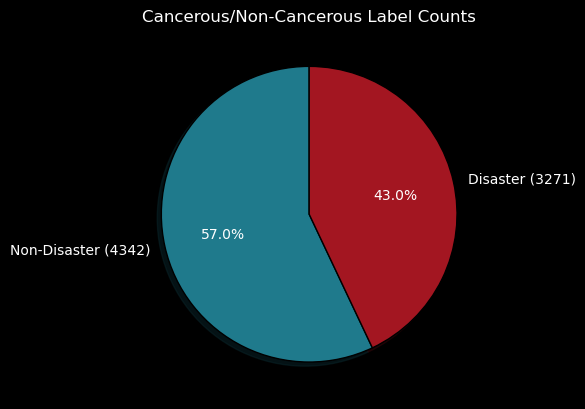

In [42]:
plt.pie(classification_counts,
        labels=labels,
        colors=[non_disaster_color, disaster_color],
        shadow=True,
        startangle=90,
        autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'})

plt.title("Cancerous/Non-Cancerous Label Counts")
plt.show()

These diagrams give us a good idea of the distribution of the target variable.  It looks like there are 4,342 (57%) non-disaster tweets and 3,271 (43%) disaster tweets. This is a fairly balanced dataset, which is good news for our model!

#### Cleaning the Data

From running the head() methods, I see there are quite a few NaN values in the keyword and location in the training data columns.  Let's see how many of these values are NaN.

In [43]:
print("----- TRAIN DATA (train_df) -----")
print(train_df.isnull().sum())


----- TRAIN DATA (train_df) -----
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


As we can see the location has many NaN values, so I will drop this column from the training data.

In [44]:
if 'location' in train_df.columns:
    train_df = train_df.drop(columns=['location'])

Next, I'll look through and see if any of the Tweets have URLs or HTML tags in their text.  If they do, I'll remove them.

In [45]:
has_urls = train_df['text'].apply(lambda x: 1 if 'http' in x else 0)
print("Number of Tweets with URLs: ", has_urls.sum())

has_html_tags = train_df['text'].apply(lambda x: 1 if '<' in x else 0)
print("Number of Tweets with HTML Tags: ", has_html_tags.sum())

Number of Tweets with URLs:  3971
Number of Tweets with HTML Tags:  0


As we can see there are a substantial number of tweets that have URLs in them but none have HTML tags.  I'll remove the URLs from the tweets.

In [46]:
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'http\S+', '', x))

Now, I'll take a look at whether or not we should remove punctuation from the tweets.

In [47]:
# TODO Remove punctuation from the tweets.

Next, I'll remove the stopwords from the tweets.  Stopwords are common words that do not add much meaning to the text.

In [48]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

train_df['text'] = train_df['text'].apply(lambda x: ' '.join(
    [word for word in word_tokenize(x) if word.lower() not in stop_words]
))



[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Great, now I'll take a look at some word clouds to get a better idea of the most common words in the tweets.

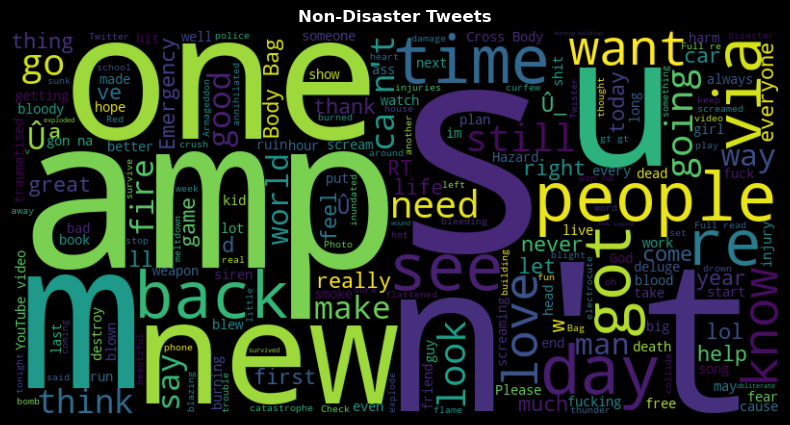

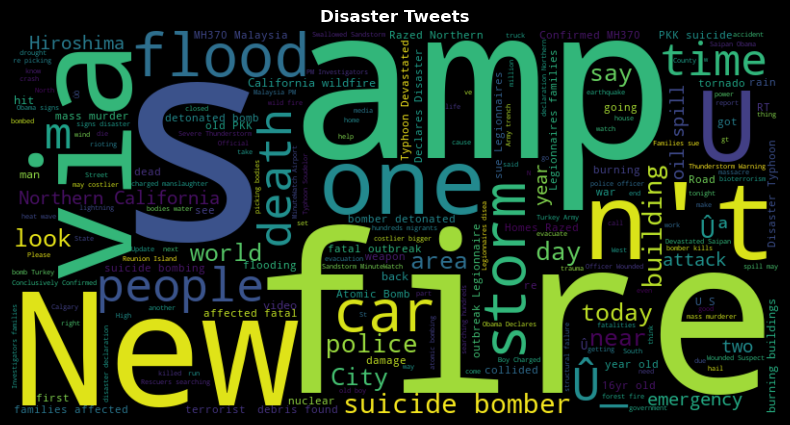

In [49]:
non_disaster_text = "".join(train_df[train_df['target'] == 0]['text'])
disaster_text = "".join(train_df[train_df['target'] == 1]['text'])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(non_disaster_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Non-Disaster Tweets", fontweight='bold')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(disaster_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Disaster Tweets", fontweight='bold')
plt.show()


## Model Architecture

#### Multiple models

For this assignment, I will be running multiple models.  Each model will be a Recurrent Neural Network (RNN) with different layers and hyperparameters.  I'll include the charts as well as some results and analysis for each model.  The models I will be looking at will be:
1. <strong>Simple/Vanilla RNN</strong> - I wanted to test a baseline model to see how well it performs.
2. <strong>LSTM</strong> - I wanted to see how well an LSTM model performs compared to the Vanilla RNN.

#### NLP Preprocessing

As we learned in the 2nd class of the Machine Learning course for this program, we need to preprocess the text data before we can use it in a model.  This includes tokenizing the text.  I'll use TF-IDF to put the text data in a matrix.  This is what I'm most familiar with after the class in the Unsupervised Learning Machine Learning course.  

First thing within the NLP Preprocessing I'll do is to tokenize the text data.  I'll use the TextVectorization layer from Keras to do this.  This will convert the text data into a matrix/sequence of numbers and also remove punctuation and lowercase the text.

In [50]:
MAX_TOKENS = 10000
SEQUENCE_LENGTH = 10

vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

vectorizer.adapt(train_df['text'].values)

#### Model #1 - Vanilla RNN

The first model I'll create is a Vanilla RNN.  This is the simplest type of RNN.  I'll use the TextVectorization layer to tokenize the text data and then pass it through the RNN.

In [51]:
def get_vanilla_rnn_model():
    EPOCHS = 20
    BATCH_SIZE = 2
    OPTIMIZER = 'adam'
    ACTIVATION_FUNCTION = 'sigmoid'
    LOSS_FUNCTION = 'binary_crossentropy'

    model = Sequential([
        vectorizer,
        Embedding(input_dim=MAX_TOKENS, output_dim=128),
        SimpleRNN(64),
        Dense(1, activation=ACTIVATION_FUNCTION)
    ])

    return model, EPOCHS, BATCH_SIZE, OPTIMIZER, LOSS_FUNCTION

Next, I'll compile and train the first model

In [52]:
vanilla_rnn_model, EPOCHS, BATCH_SIZE, OPTIMIZER, LOSS_FUNCTION = get_vanilla_rnn_model()

vanilla_rnn_model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=['accuracy'])

vanilla_rnn_model_history = vanilla_rnn_model.fit(
    train_df['text'].values,
    train_df['target'].values,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2
)

vanilla_rnn_model.summary()

Epoch 1/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6738 - loss: 0.5929 - val_accuracy: 0.7636 - val_loss: 0.5228
Epoch 2/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8913 - loss: 0.2930 - val_accuracy: 0.7452 - val_loss: 0.5528
Epoch 3/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9521 - loss: 0.1458 - val_accuracy: 0.7118 - val_loss: 0.7690
Epoch 4/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9665 - loss: 0.0925 - val_accuracy: 0.6796 - val_loss: 0.8158
Epoch 5/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9705 - loss: 0.0825 - val_accuracy: 0.6638 - val_loss: 0.8387
Epoch 6/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9766 - loss: 0.0621 - val_accuracy: 0.6205 - val_loss: 1.0198
Epoch 7/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9782 - loss: 0.0600 - val_accuracy: 0.6454 - val_loss: 1.0541
Epoch 8/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9826 - loss: 0

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (2, 10)                │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (2, 10, 128)           │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (2, 64)                │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (2, 1)                 │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,877,253 (14.79 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,584,836 (9.86 MB)

Alright, now let's take a look at some graphs from the first model.  Here we can see the loss and accuracy of the model.

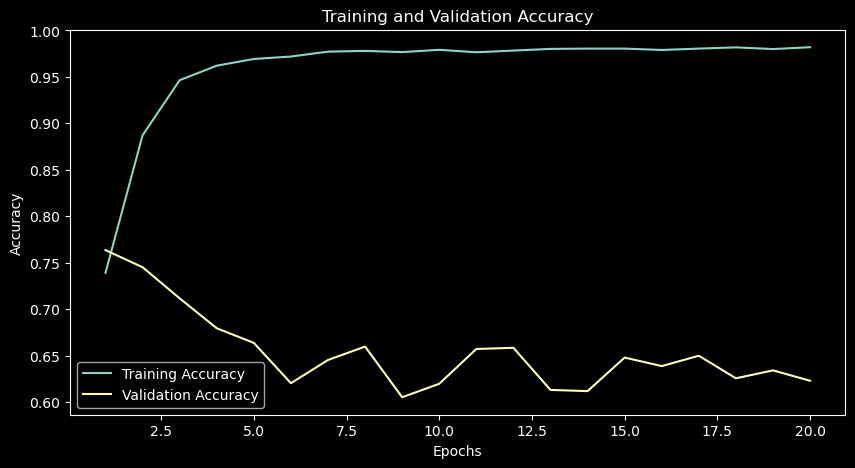

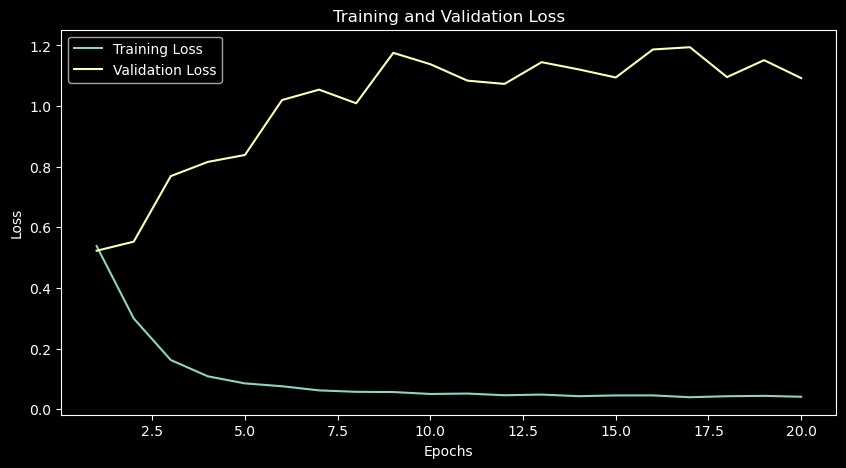

In [53]:
def plot_training_metrics(history):

    print(history)
    # Extract metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_accuracy) + 1)

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_metrics(history=vanilla_rnn_model_history)


As we can see Training Accuracy vs Validation Accuracy, the model is overfitting.  The training accuracy approaches near 100% quite quickly.  The model learns the training data very well but fails to perform well on the validation data.

From the Training and Validation Loss graph, we can see that the model is overfitting.  The training loss is decreasing while the validation loss is increasing.

Now, I'll go ahead and make the predictions on the test data and look at some more metrics.

In [54]:
vanilla_rnn_model_predictions = vanilla_rnn_model.predict(train_df['text'].values)
vanilla_rnn_model_binary = (vanilla_rnn_model_predictions > 0.5).astype(int).flatten()

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


I'll take a look at the confusion matrix for the first model.

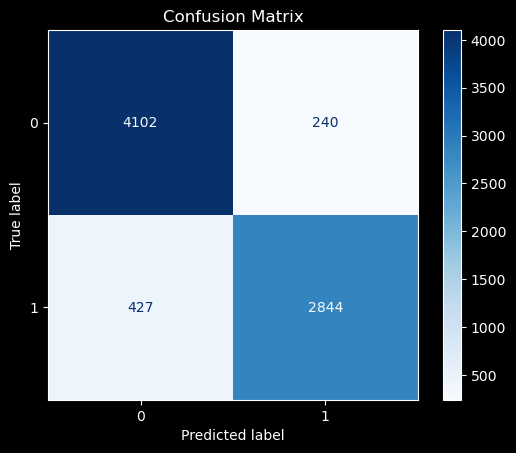

In [55]:
def plot_confusion_matrix(binary_predictions):
    conf_matrix = confusion_matrix(train_df['target'].values, binary_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(binary_predictions=vanilla_rnn_model_binary)


The confusion matrix shows a pretty good result.  The model is predicting the disaster tweets fairly well.  However, these numbers are quite high and I suspect there is some overfitting going on.

I'll also want to see how well this model performs on the test data and on the Kaggle leaderboard.  Here I'll make predictions on the test data and then submit the predictions to Kaggle.

In [56]:
def create_submission(model, filename):
    predictions = model.predict(test_df['text'].values)
    test_df['target'] = (predictions > 0.5).astype(int)

    submission = test_df[['id', 'target']]
    submission.to_csv(f"submissions/{filename}", index=False)
    test_df.drop(columns=['target'], inplace=True)

In [57]:
create_submission(model=vanilla_rnn_model, filename='submission_1_vanilla_rnn_basic.csv')

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


Great, now let's see where this lands on the Kaggle leaderboard.

In [90]:
def display_kaggle_results(filename):
    image_types = ['results', 'leaderboard']
    for i in range(len(image_types)):
        screenshot = f"submissions/screenshots/{filename}_{image_types[i]}.png"
        if os.path.isfile(screenshot):
            image = mpimg.imread(screenshot)

            plt.figure(figsize=(12, 4))
            plt.imshow(image)
            plt.axis('off')
            plt.show()

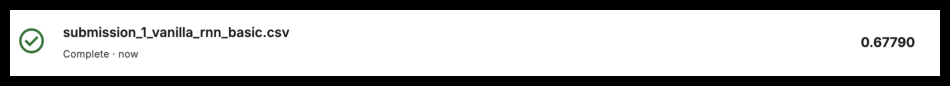

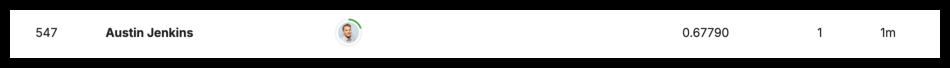

In [91]:
display_kaggle_results("submission_1_vanilla_rnn_basic")

##### Analysis of Model #1:

- The model is overfitting
- It performed reasonably well on the submission to Kaggle.  It scored a ~0.68 score landing me in 547th place on the leaderboard.  

#### Model #2 - Vanilla RNN with Dropout, BatchNormalization and EarlyStopping

The second model I'll create will expand on the Vanilla/SimpleRNN approach.  Here I'll adjust some of the hyperparameters to see if I can improve the model.  I'll add Dropout, BatchNormalization, and EarlyStopping to the model.

Key Changes:
- Dropout: I'll add a dropout layer to the model to help prevent overfitting.
- BatchNormalization: I'll add a BatchNormalization layer to the model to help normalize the data.
- EarlyStopping: I'll add an EarlyStopping callback to the model to stop training when the validation loss stops decreasing.
- Activation Function: I'll change the activation function to 'relu' to see if this improves the model.
- Learning Rate: I'll add a learning rate to the model to see if this improves the model.
- Optimizer: I'll change the optimizer to RMSProp to see if this improves the model.

In [60]:
def get_vanilla_rnn_v2_model():
    EPOCHS = 20
    BATCH_SIZE = 2
    LEARNING_RATE = 0.001
    OPTIMIZER = RMSprop(learning_rate=LEARNING_RATE)
    ACTIVATION_FUNCTION = 'relu'
    LOSS_FUNCTION = 'binary_crossentropy'

    model = Sequential([
        vectorizer,
        Embedding(input_dim=MAX_TOKENS, output_dim=128),
        SimpleRNN(64, return_sequences=False),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation=ACTIVATION_FUNCTION)
    ])

    return model, EPOCHS, BATCH_SIZE, OPTIMIZER, LOSS_FUNCTION

In [61]:
vanilla_rnn_model_v2, EPOCHS, BATCH_SIZE, OPTIMIZER, LOSS_FUNCTION = get_vanilla_rnn_v2_model()
vanilla_rnn_model_v2.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

vanilla_rnn_model_v2_history = vanilla_rnn_model_v2.fit(
    train_df['text'].values,
    train_df['target'].values,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping]
)

vanilla_rnn_model_v2.summary()


Epoch 1/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5447 - loss: 6.0034 - val_accuracy: 0.4517 - val_loss: 6.7685
Epoch 2/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5824 - loss: 4.7390 - val_accuracy: 0.4655 - val_loss: 8.5042
Epoch 3/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5749 - loss: 1.2027 - val_accuracy: 0.5345 - val_loss: 7.4687
Epoch 4/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6238 - loss: 0.9665 - val_accuracy: 0.4675 - val_loss: 5.8040
Epoch 5/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6525 - loss: 1.1032 - val_accuracy: 0.5903 - val_loss: 6.4815
Epoch 6/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6559 - loss: 2.2158 - val_accuracy: 0.7078 - val_loss: 3.4186
Epoch 7/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7207 - loss: 2.9848 - val_accuracy: 0.6343 - val_loss: 5.6862
Epoch 8/20
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7376 - loss: 3

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (2, 10)                │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (2, 10, 128)           │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (2, 64)                │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (2, 64)                │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (2, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (2, 1)                 │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,585,220 (9.86 MB)

 Trainable params: 1,292,545 (4.93 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 1,292,547 (4.93 MB)

Here we can see that by adding the early stopping, the model stopped training after 7 epochs making it more efficient and should help prevent some of the overfitting we experienced in the first model.

Next, we'll take a look at some of the graphs from the second model.

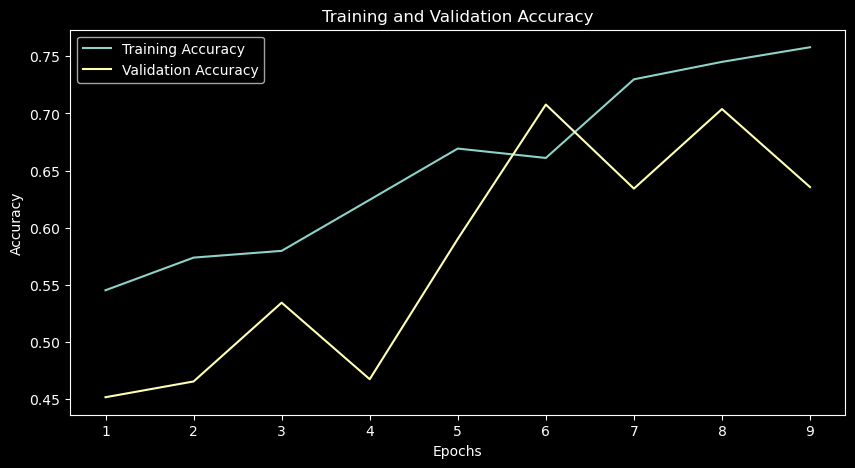

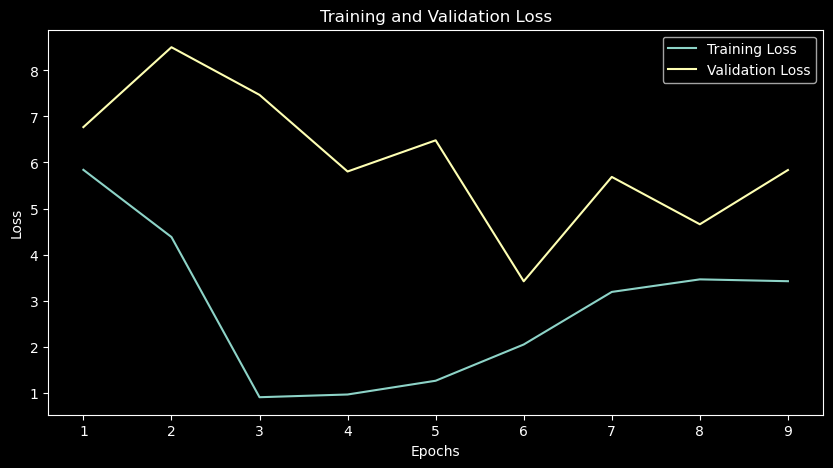

In [62]:
plot_training_metrics(history=vanilla_rnn_model_v2_history)

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


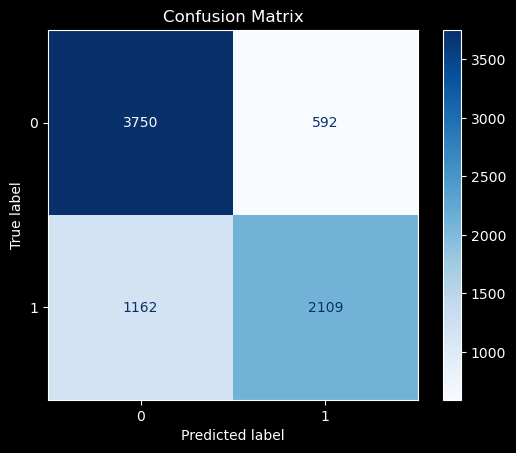

In [64]:
vanilla_rnn_model_v2_predictions = vanilla_rnn_model_v2.predict(train_df['text'].values)
vanilla_rnn_model_v2_binary = (vanilla_rnn_model_v2_predictions > 0.5).astype(int).flatten()
plot_confusion_matrix(binary_predictions=vanilla_rnn_model_v2_binary)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


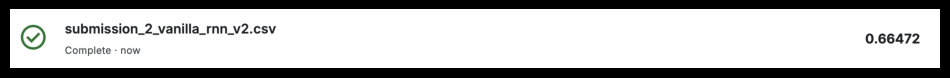

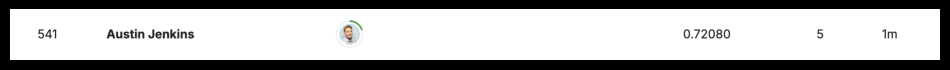

In [92]:
filename='submission_2_vanilla_rnn_v2'
create_submission(model=vanilla_rnn_model_v2, filename=f"{filename}.csv")
display_kaggle_results(filename)

##### Analysis of Model #2:

Overall, the score increased slightly.  This bumped up my rank 6 places to the 541st position on the leaderboard.  The early stopping helped to prevent the model from training too long and adding dropout, batch normalization, and changing the optimizer to RMSProp helped to improve the model slightly.

#### Model #3 - Vanilla RNN with Hyperparameter Tuning

## Results & Analysis

## Conclusion


Recommendations for future:
- Try using GloVe embeddings

## References

- https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-implementation
- https://www.kaggle.com/code/tuckerarrants/disaster-tweets-eda-glove-rnns-bert
- https://www.kaggle.com/code/shirishsharma/nlp-from-embeddings-and-rnns-to-bert
- https://www.kaggle.com/code/keithrek/rnn-lstm-disaster-tweets-nlp
- https://www.kaggle.com/code/jagdmir/tweet-analysis-simplernn-lstm-gru